In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), device

(0, device(type='cpu'))

In [2]:
import os
import sys
IS_GCOLAB = 'google.colab' in sys.modules

In [3]:
from pathlib import Path

_base_libpath = Path(
    "/content/drive/MyDrive" if IS_GCOLAB else f"{os.environ['HOME']}"
) / "_self_research/24.09.world_cuisine"
assert _base_libpath.exists()

os.chdir(_base_libpath)

In [4]:
if IS_GCOLAB:
    raise NotImplementedError()
    # from google.colab import drive
    # drive.mount('/content/drive')
    # # os.environ.setdefault("", "1")
    # # os.system("pip install transformers==4.33.1")
    # os.system("pip install transformers sudachitra accelerate")
    # os.system("pip install langchain tiktoken openai")
    # os.system("pip install -U langchain-community")
    # os.system("pip install -U datasets pyarrow")

else:
    # raise NotImplementedError()
    print(">>> Not on Google Colab <<<")

>>> Not on Google Colab <<<


---

In [5]:
# import datasets
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from sentence_transformers import SentenceTransformer

import os
import requests
import pickle
from PIL import Image
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

import re
import json
from collections import Counter

In [6]:
df = pd.read_csv("WorldCuisines - Food.csv")
print(f"Cuisine counts: {len(df):6,}")
df = df.loc[df.loc[:,'Image1 name / URL'].notna()].reset_index(drop=True)
print(f"  w/ imgs only: {len(df):6,}")

Cuisine counts:  2,613
  w/ imgs only:  1,229


In [ ]:
# df = pd.read_csv("WorldCuisines - Food.240919.csv")

Cuisine counts:  2,507
  w/ imgs only:    791


In [7]:
fps = []
for _ in range(1,9):
    wew = df.loc[:,f"Image{_} name / URL"].dropna()
    fps.extend(wew.tolist())
fps = pd.Series(fps)

In [8]:
wew = fps.map(lambda t: t[:-len("?download")].lower() if t.endswith("?download") else t.lower())
assert not wew[~(
    wew.str.endswith(".jpg") | wew.str.endswith(".jpeg")
    | wew.str.endswith(".png") | wew.str.endswith(".gif") | wew.str.endswith(".tif")
)].tolist()
# print(len(wew), len(wew.unique()))

In [9]:
print(f"Image Count: {len(fps):,}")
fps = fps[~wew.duplicated()].reset_index(drop=True)
print(f"  Unique # : {len(fps):,}")

Image Count: 3,397
  Unique # : 3,367


In [ ]:
# as of 240919

2301
2284


---

In [ ]:
# assert all(fps[fps.str.startswith("http")].str.startswith("https://"))

In [ ]:
def get_img_size(fp):
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    try:
        if fp.startswith("https://"):
            response = requests.get(fp, headers=headers, stream=True, timeout=8)
            response.raise_for_status()
            _img = response.raw
        else:
            _img = _base_libpath / "images" / fp
        image = Image.open(_img).convert('RGB')
        return image.size
    except Exception as e:
        # print(fp, e)
        return None

In [ ]:
from multiprocessing import Pool

In [ ]:
%%time
with Pool(processes=32) as pool:
    async_result = pool.map_async(get_img_size, fps.tolist(), 16)
    async_result.wait()

CPU times: user 77.7 ms, sys: 177 ms, total: 255 ms
Wall time: 1min 34s


In [ ]:
sizes = async_result.get()

In [ ]:
len(sizes), len(list(filter(None, sizes))), f"{len(list(filter(None, sizes)))/len(sizes):.1%}"

(2284, 2252, '98.6%')

In [ ]:
# Previous count when total images was 1871

(1856, 1833, '98.8%')

---

In [ ]:
import seaborn as sns

In [ ]:
df = pd.DataFrame(list(filter(None, sizes)), columns=["width", "height"])

In [ ]:
df

,width,height
0,1920,1440
1,1531,1198
2,1564,1199
3,1920,1285
4,1920,1440
...,...,...
2247,1280,960
2248,1440,1080
2249,1434,1080
2250,1280,960


In [ ]:
df["hue"] = ""

In [ ]:
g = sns.JointGrid(df, x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=20, alpha=.1)
g.plot_marginals(sns.histplot, kde=True, linewidth=0, palette=["g"])

as of 240919

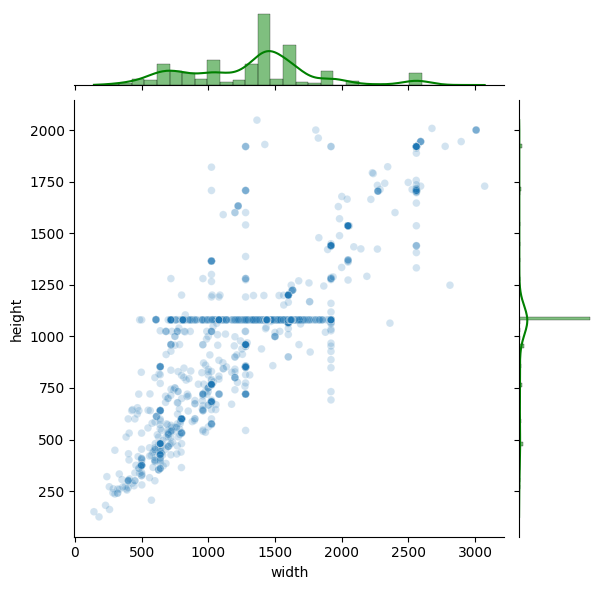

In [ ]:
g = sns.JointGrid(df.loc[df.width.le(3072)&df.height.le(2048)], x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=30, alpha=.2)
g.plot_marginals(sns.histplot, kde=True, linewidth=.2, palette=["g"])

---
---
---

In [10]:
df_all = pd.read_csv("WorldCuisines - Food.csv")
print(f"Cuisine counts: {len(df_all):6,}")
df_w_img = df_all.loc[df_all.loc[:,'Image1 name / URL'].notna()].reset_index(drop=True)
print(f"   has images : {len(df_w_img):6,}")
df_w_reg = df_all[df_all.loc[:,'Region1'].notna()].reset_index(drop=True)
print(f"   has Region1: {len(df_w_reg):6,}")

Cuisine counts:  2,613
   has images :  1,229
   has Region1:  1,304


In [11]:
print("--- No Images stats ---")
# print(f"Has Region1, w/o imgs. #: {sum(df_all.loc[:,'Region1'].notna())-len(df_w_img):6,}")
print(f"w/ Region1, w/o imgs.: {len(df_w_reg[df_w_reg.loc[:,'Image1 name / URL'].isna()]):6,}")
print(f"    =>  w/  Text Desc. # : {len(df_w_reg[df_w_reg.loc[:,'Text Description'].notna() & df_w_reg.loc[:,'Image1 name / URL'].isna()]):6,}")
print(f"    =>  w/o Text Desc. # : {len(df_w_reg[df_w_reg.loc[:,'Text Description'].isna()]):6,}")

--- No Images stats ---
w/ Region1, w/o imgs.:     75
    =>  w/  Text Desc. # :     73
    =>  w/o Text Desc. # :      2


In [ ]:
df_w_reg.iloc[:,16]

0       The soup is composed of a ground mixture of ga...
1       The soup is made of beef or beef offal, cooked...
2       The soup is a clear beef soto that has pieces ...
3       The soup is spiced with star anise, clove, cas...
4       The soup consists of shredded chicken, bean sp...
                              ...                        
1299    a long golden-brown deep-fried strip of wheat ...
1300    This dish has flaky version and cake-dough ver...
1301    the jelly is made by boiling the aged and slig...
1302    This dish consists of strips of raw fish (some...
1303    a steamed rice roll serve with shrimp paste or...
Name: Text Description, Length: 1304, dtype: object

In [ ]:
print("NaN categories also got.\nNo Cuisine also got..\n:\\")
df_w_reg[df_w_reg.loc[:,"Coarse-grained categories"].isna()|df_w_reg.loc[:,"Cuisines"].isna()].iloc[:,:-17]

NaN categories also got.
No Cuisine also got..
:\


,Count,Name,Assigned,Alias,Wikipedia Link,Coarse-grained categories,Fine-grained categories,Cuisines,Associated Cuisines,Area,Countries,Region1,Region2,Region3,Region4,Region5,Text Description
38,1,Albaloo polo,NaN,آلبالو پلو,https://en.wikipedia.org/wiki/Albaloo_polo,NaN,NaN,"[""Iran""]","[""Shiraz""]","[""Shiraz""]","[""Iran""]",South Asia,NaN,NaN,NaN,NaN,The dish is made with rice and sour cherries u...
1138,1,Ugali,Ubaidillah Ariq Prathama,NaN,https://en.wikipedia.org/wiki/Ugali,NaN,NaN,"[""Kenya"",""Tanzania""]","[""Kenya"",""Tanzania""]","[""Kenya"",""Tanzania""]","[""Kenya"",""Tanzania"", ""Uganda"", ""Tanzania"", ""Zi...",West Africa,East Africa,South Africa,NaN,NaN,The dish is a type of corn meal made from maiz...


In [ ]:
print("Got categories and cuisines, but no description..")
df_w_reg[df_w_reg.loc[:,"Coarse-grained categories"].notna()&df_w_reg.loc[:,"Cuisines"].notna()&df_w_reg.loc[:,"Text Description"].isna()].iloc[:,:-17]

Got categories and cuisines, but no description..


,Count,Name,Assigned,Alias,Wikipedia Link,Coarse-grained categories,Fine-grained categories,Cuisines,Associated Cuisines,Area,Countries,Region1,Region2,Region3,Region4,Region5,Text Description
424,1,French Fries,NaN,NaN,https://en.wikipedia.org/wiki/French_fries,"[""Potato""]","[""Deep-Fried Potato""]","[""United States"", ""Canada""]",NaN,"[""United States"", ""Canada""]",NaN,North America,NaN,NaN,NaN,NaN,NaN
643,1,Butter pecan,NaN,NaN,https://en.wikipedia.org/wiki/Butter_pecan,['Dessert'],['ice cream'],['America'],['America'],['America'],['America'],North America,NaN,NaN,NaN,NaN,NaN


Let's check the stats

In [12]:
df = df_w_reg[df_w_reg.loc[:,"Coarse-grained categories"].notna()&df_w_reg.loc[:,"Cuisines"].notna()&df_w_reg.loc[:,"Text Description"].notna()]
print(f"Somewhat OK count: {len(df)}")

Somewhat OK count: 1300


In [13]:
# @title
def parse_txt(t):
    if t is np.nan:
        return []
    t = t.replace('"Liberia"m"Cote D\'Ivoire"', '"Liberia", "Cote D\'Ivoire"')
    t = t.replace("''", '"')
    t = re.sub(r"[‘'’“]", '"', t)
    t = re.sub(r'", ([A-Z])', r'", "\1', t)
    t = re.sub(r'([a-z])\]', r'\1"]', t)
    t = re.sub(r'([a-z]), "', r'\1", "', t)
    t = (t
            .replace('" "', '", "')
            .replace('"."', '", "')
            .replace(", and ", ", ")
            .replace('d"Ivoire', "d'Ivoire")
            .replace('D"Ivoire', "D'Ivoire")
        )
    try:
        t = json.loads(t)
    except Exception as e:
        print(" >>> lho:", t)
        raise e
    return t


In [14]:
entries = df.loc[:,[
    'Coarse-grained categories', 'Fine-grained categories', 'Cuisines',
    'Associated Cuisines', 'Area', 'Countries'
    ]]

In [15]:
counters = {}
for c in range(6):
    counter = Counter([e.lower() for _ in entries.iloc[:,c].apply(parse_txt) for e in _])
    counters[entries.columns[c]] = counter
    print(entries.columns[c], f"  (total:  {sum(counter.values()):,})")
    print(counter, end="\n\n")

Coarse-grained categories   (total:  1,499)
Counter({'rice': 220, 'pastry': 196, 'snack': 182, 'dessert': 144, 'noodle': 113, 'bread': 91, 'meat': 69, 'cake': 45, 'soup': 40, 'egg': 40, 'pancake': 33, 'stew': 27, 'side dish': 25, 'dumpling': 23, 'tofu': 21, 'cookie': 20, 'sandwich': 19, 'vegetable': 19, 'biscuit': 16, 'sweet': 13, 'fish': 11, 'dim sum': 10, 'salad': 9, 'fritter': 9, 'seafood': 6, 'cutlet': 6, 'potato': 6, 'pasta': 5, 'skewer': 5, 'roll': 5, 'vegetables': 4, 'wrap': 4, 'crepe': 4, 'doughnut': 4, 'chicken': 3, 'hot pot': 3, 'shrimp': 2, 'dough': 2, 'lamb': 2, 'omelette': 2, 'cold dessert': 2, 'chili paste': 2, 'corn': 2, 'pudding': 2, 'stir fry': 2, 'seaweed': 2, 'sugar': 2, 'candy': 2, 'tortilla': 2, 'fruit': 1, 'shellfish': 1, 'drinks': 1, 'rice cake': 1, 'cereal': 1, 'curry': 1, 'dimsum': 1, 'canned food': 1, 'finger food': 1, 'soybeans': 1, 'bean': 1, 'flatbread': 1, 'cookies': 1, 'beans': 1, 'flour': 1, 'jelly': 1, 'poultry': 1, 'pizza': 1, 'spread': 1, 'grill': 1, 

In [ ]:
print("List of countries and cuisines so far:")
print(*sorted(counters["Cuisines"].keys() | counters["Associated Cuisines"].keys() | counters["Countries"].keys()), sep="\n")

List of countries and cuisines so far:
aachen
afghanistan
africa
albania
algeria
amdo
america
american south
anatolia
andhra pradesh
anglosphere
angola
anguilla
arab
arab world
arabian peninsula
argentina
armenia
ashkenazi jewish
assamese
australia
austria
austronesian
azerbaijan
bahamas
balkan
balkans
bangladesh
barbados
belarus
belarusia
belarusian
belgium
bengal
bengali
benin
bhojpuri
bhutan
bihar
bolivia
bosnia
bosnia and herzegovina
brazil
britain
brunei
bulgaria
burkina faso
burma
burmese
buryatia
cagayan
cambodia
cambodian
cameroon
canada
canada, caribbean
canton
cantonese
cape verde
carribean
caspian
catalan
catalonia
caucasus
cebu
central african republic
central america
central asia
central asian
central luzon
central thailand
chad
chian
chiayi county
chifa
chile
china
chinese
chinese peruvian
colombia
colombian
congo
costa rica
cote d'ivoire
croatia
cuba
cyprus
czech
czech republic
czezch
denmark
dominica
dominican
dominican republic
east asia
east german
east timor
eastern 

In [26]:
for c, cnt in sorted((counters["Cuisines"] + counters["Countries"] + counters["Associated Cuisines"]).items()):
    print(c, cnt, sep='\t')

aachen	2
afghanistan	6
africa	3
albania	11
algeria	9
amdo	1
america	13
american south	1
anatolia	3
andhra pradesh	1
anglosphere	2
angola	2
anguilla	1
arab	3
arab world	7
arabian peninsula	4
argentina	22
armenia	35
ashkenazi jewish	6
assamese	2
australia	39
austria	54
austronesian	1
azerbaijan	21
bahamas	2
balkan	8
balkans	5
bangladesh	34
barbados	1
belarus	10
belarusia	1
belarusian	2
belgium	12
bengal	2
bengali	3
benin	6
bhojpuri	1
bhutan	1
bihar	1
bolivia	12
bosnia	4
bosnia and herzegovina	5
brazil	85
britain	3
brunei	41
bulgaria	15
burkina faso	2
burma	1
burmese	3
buryatia	3
cagayan	1
cambodia	18
cambodian	1
cameroon	11
canada	48
canada, caribbean	1
canton	2
cantonese	15
cape verde	1
carribean	2
caspian	1
catalan	1
catalonia	2
caucasus	3
cebu	2
central african republic	1
central america	1
central asia	7
central asian	2
central luzon	2
central thailand	1
chad	1
chian	2
chiayi county	1
chifa	1
chile	19
china	337
chinese	2
chinese peruvian	1
colombia	15
colombian	2
congo	1
costa rica	6
